# Genetic Programming

Genetic Programming uses the same framework defined in Genetic Algorithms.
The main difference is that in GP the individuals are in the form of computer programs.


## Representation

### Parsing Tree
One of the possible representations of a computer program, is a parsing tree.

A **parsing tree** is a tree in which:
- internal nodes are elements of a set $\mathcal{F}$ containig functions;
- leaves are elements of a set $\mathcal{T}$ called terminal set.

<img src="img/parsing_tree.png" alt="GA flow" width="200"/>

The terminal set contains constants 
(e.g. $1,2,true,\pi,\dots$) and variables.

Functions and terminals are called primitives. The primitives set must respect the property of **closure**: the terminals and the output of any function must be valid inputs to all the functions.

The primitives set should also respect the property of **sufficiency**: the primitives must be sufficient to represent the solution of the problem.

### Automatically Defined Functions
In computer programs, we have subroutines that can be called several times by a program. In GP, we represent subroutines using **Automatically Defined Functions**. We select how many ADF we need for solving the problem and the number of arguments that each ADF accepts.

The individuals are now vectors of tree, the geentic operation must be applied to the elemnts of this vector.

<img src="img/adf.png" alt="adf" width="400"/>


## Initialization Method

- **Grow** Method: up to a maximum depth of the parsing tree, select randomly across all primitives. Once the maximum depth is reached select a terminal until every
leaf is filled.

- **Full** Method: up to a maximum depth of the parsing tree, select randomly across functions. Once the maximum depth is reached select a terminal until every
leaf is filled. This means that terminals appear only in the last level of the tree.

- **Ramped Half and Half**: this method combines both Grow and Full method. The maximum depth is randomly fixed and at every step the choice between Grow and Full is made randomly.

- **Ephemeral Constants**: Generally, constats belong to the terminal set. An alternative is to use epehemeral constants, i.e. generating a random constant from a distribution.

## Crossover Method

We say that a crossover method is **homologous** if we do not obtain a different individual by crossing the original individual with itself. The classical GA crossovers with binary representation are homologous. This is not usually the case for GP.



### Subtree Crossover
Given two parsing trees and selected a subtree from each tree, we swap the subtrees between the two individuals.
Subtree Crossover is non-homologous. 

<img src="img/subtree_crossover.png" alt="subtree crossover" width="400"/>


## Mutation
There exist several types of mutation:
- **subtree** mutation, a subtree is replaced by a new random subtree;
- **point** mutatin, a node is replaced by a compatible node;
- **hoist** mutation, entire tree is replaced by a subtree;
- **shrink** mutation, a subtree is replaced by a terminal;
- **swap** mutation, apply a permutation to the arguments of a function


### Bloat
**Bloat** is a condition that occurs when the fitness of the individuals does not increase as the size of the of the trees grows. It is caused by large non-coding regions.

To avoid bloat, we may set a limit to individual size (maximum depth, hoist/shrink mutation, etc.), remove non-coding regions or adding a penalty to individuals that are too big.

We can define adjusted fitness with linear parsimony pressure as
$$
    f_{\text{adjusted}} = \alpha f - (1-\alpha)s
$$
where $s$ is a measure of the size of the tree and $\alpha \in [0,1]$ determines the penlty to the size.

## Introduction using GPLearn

[GPLearn](https://github.com/trevorstephens/gplearn) is a GP framework that uses an API similar to scikit-learn. In this example we will try to solve a symbolic regression problem, in two dimensions (i.e., with two input variables). 

First of all, we import the necessary library, including the ones used for plotting

In [2]:
import gplearn.genetic as gp
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib
import sklearn.utils as skutil
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

Here we define the target function as $f(x,y) = \sin(3x) + \sin(3y)$. You can change it in any way you want

In [3]:
def target(x, y):
    return np.sin(3*x) + np.sin(3*y)

The function that we want to learn is then evaluated in $10^5$ equally sapaced points in $[-1,1] \times [-1,1]$

In [4]:
x_coords = np.linspace(-1, 1, 100)
y_coords = np.linspace(-1, 1, 100)
x_coords, y_coords = np.meshgrid(x_coords,y_coords)
target_points = target(x_coords,y_coords)

Here we display the target function

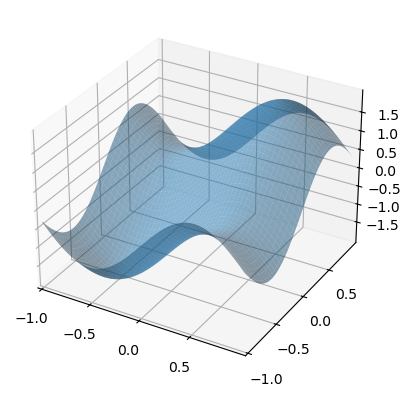

In [5]:
plt.figure()
ax = plt.axes(projection='3d')
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.set_xticks(np.arange(-1,1,.5))
ax.set_yticks(np.arange(-1,1,.5))
ax.plot_surface(x_coords, y_coords, target_points, alpha=0.5)
plt.show()

For the learning process we select $100$ random points in $[-1,1]\times[-1,1]$. That is, GP does not have direct access to the function but only to a subset of points sampled from it.

In [6]:
rng = skutil.check_random_state(0)

x_train = rng.uniform(-1, 1, 100).reshape(50, 2)
y_train = target(x_train[:, 0], x_train[:, 1])

Here we perform the actual GP run. Usually we can directly set the parameter `generations` to the maximum number of generations. Here, however, we stop after every generation to collect the best individual at that generation.

The set of functional sysmbols contains, in addition to the usual $+$, $\times$, $-$ and $\div$, also the functions $\sin$, $\cos$, $\sqrt{\cdot}$. Try to change them to see how the solutions found change.

In [7]:
fset=('add', 'sub', 'mul', 'div', 'sin', 'cos', 'sqrt')
predicted_data = []
max_gen = 50
sr = gp.SymbolicRegressor(population_size=500,
                          generations=1,
                          function_set=fset,
                          stopping_criteria=0.01,
                          p_crossover=0.8, # Probability of performing subtree crossover
                          p_subtree_mutation=0.1, # Probability of subtree mutation
                          p_hoist_mutation=0.05, # Small probability of hoist mutation
                          p_point_mutation=0.05, # Small probability of point mutation
                          parsimony_coefficient=0.01, # Penalization of large trees
                          verbose=0, # Set to 1 to obtain the fitness values
                          random_state=0,
                          warm_start=True)
for i in range(0, max_gen+1):
    sr.set_params(generations=i+1)
    sr.fit(x_train, y_train)
    predicted_data.append(sr.predict(np.c_[x_coords.ravel(),y_coords.ravel()]).reshape(x_coords.shape))

FInally, we display the functions found by the GP process. It is possible to check how the solution changes with time.

In [8]:
def print_results(i):
    plt.figure()
    ax = plt.axes(projection='3d')
    ax.set_xlim(-1,1)
    ax.set_ylim(-1,1)
    ax.set_xticks(np.arange(-1,1,.5))
    ax.set_yticks(np.arange(-1,1,.5))
    ax.plot_surface(x_coords, y_coords, predicted_data[i], alpha=0.5, color='red')
    ax.plot_surface(x_coords, y_coords, target_points, alpha=0.1)

interact(print_results, i=widgets.IntSlider(min=0,max=50,step=5,value=0))
plt.show()

interactive(children=(IntSlider(value=0, description='i', max=50, step=5), Output()), _dom_classes=('widget-in…

As it is possible to observe, after about $30$ generations, GP was able to find the optimal solution.

The resulting program is:

In [9]:
print(sr._program)

add(sin(add(X0, add(X0, X0))), sin(add(X1, add(X1, X1))))
